# Burger's Equation in 2D

Here we explore numerical solutions to Burger's equation in 2D, which can be written in vector form as

\begin{align}
  \frac{\partial \vec{u}}{\partial t} 
  + \left(\vec{u}\cdot\nabla\right)\vec{u} 
  = \nu\nabla^2\vec{u}
\end{align}

where the diffusion coefficient, $\nu$, is taken to be constant, and $\vec{u}(x,y,t)$ is a two-component vector

\begin{align}
  \vec{u} =
  \left[\begin{array}{}
    u \\
    v
  \end{array}\right],
\end{align}

with $u=u(x,y,t)$ and $v=v(x,y,t)$. When written in component form, this yields the two coupled scalar equations

\begin{align}
  & \frac{\partial u}{\partial t}
  + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} 
  = \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
  \\
  & \frac{\partial v}{\partial t}
  + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} 
  = \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right).
\end{align}

As with Burger's equation in 1D, here we use a hybrid finite difference scheme. We treat time derivatives with forward differences, first-order spatial derivatives with backward differences, and second spatial derivatives with centered differences. This yields the difference equations

\begin{align}
  & u^{n+1}_{i,j} = u^{n}_{i,j} 
  - \frac{\Delta{t}}{\Delta{x}}u^{n}_{i,j}\left(u^{n}_{i,j} - u^{n}_{i-1,j}\right)
  - \frac{\Delta{t}}{\Delta{y}}v^{n}_{i,j}\left(u^{n}_{i,j} - u^{n}_{i,j-1}\right) 
  \\ & \quad\quad\quad
  + \frac{\nu\Delta{t}}{(\Delta{x})^2}\left(u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}\right)
  + \frac{\nu\Delta{t}}{(\Delta{y})^2}\left(u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}\right)
\end{align}

\begin{align}
  & v^{n+1}_{i,j} = v^{n}_{i,j} 
  - \frac{\Delta{t}}{\Delta{x}}u^{n}_{i,j}\left(v^{n}_{i,j} - v^{n}_{i-1,j}\right)
  - \frac{\Delta{t}}{\Delta{y}}v^{n}_{i,j}\left(v^{n}_{i,j} - v^{n}_{i,j-1}\right)
  \\ & \quad\quad\quad
  + \frac{\nu\Delta{t}}{(\Delta{x})^2}\left(v^{n}_{i+1,j} - 2v^{n}_{i,j} + v^{n}_{i-1,j}\right)
  + \frac{\nu\Delta{t}}{(\Delta{y})^2}\left(v^{n}_{i,j+1} - 2v^{n}_{i,j} + v^{n}_{i,j-1}\right).
\end{align}

If we use a uniform grid with $h \equiv \Delta{x} = \Delta{y}$, these simplify to

\begin{align}
  & u^{n+1}_{i,j} = u^{n}_{i,j} 
  - \frac{\Delta{t}}{h}\left[u^{n}_{i,j}\left(u^{n}_{i,j} - u^{n}_{i-1,j}\right)
  + v^{n}_{i,j}\left(u^{n}_{i,j} - u^{n}_{i,j-1}\right)\right] 
  \\ & \quad\quad\quad
  + \frac{\nu\Delta{t}}{h^2}\left[u^{n}_{i+1,j} + u^{n}_{i-1,j} 
  + u^{n}_{i,j+1} + u^{n}_{i,j-1} - 4u^{n}_{i,j}\right]
\end{align}

\begin{align}
  & v^{n+1}_{i,j} = v^{n}_{i,j} 
  - \frac{\Delta{t}}{h}\left[u^{n}_{i,j}\left(v^{n}_{i,j} - v^{n}_{i-1,j}\right)
  + v^{n}_{i,j}\left(v^{n}_{i,j} - v^{n}_{i,j-1}\right)\right] 
  \\ & \quad\quad\quad
  + \frac{\nu\Delta{t}}{h^2}\left[v^{n}_{i+1,j} + v^{n}_{i-1,j} 
  + v^{n}_{i,j+1} + v^{n}_{i,j-1} - 4v^{n}_{i,j}\right]
\end{align}

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# function to evolve the 2D diffusion equation    
def burger2D(Lx, Ly, nx, ny):
    """
    this evolves solutions to Burger's equation in 2D
    
    Lx = size of spatial grid in the x direction
    Ly = size of spatial grid in the y direction
    nx = total number of spatial grid points in the x direction
    ny = total number of spatial grid points in the y direction
    """
    # diffusivity
    nu = 0.01
    #print('diffusion coefficient is',nu)

    # setup spatial grid (vertex-centered)
    dx = Lx/(nx-1)   # grid spacing in x direction
    dy = Ly/(ny-1)   # grid spacing in y direction
    x = np.linspace(0, Lx, nx) # x grid
    y = np.linspace(0, Ly, ny) # y grid
    #print('x grid spacing is',dx)
    #print('y grid spacing is',dy)

    # setup time grid
    sigma = 0.05
    dt = sigma*dx*dy/nu # size of timesteps
    nt = 100            # total number of timesteps
    #print('time stepsize is',dt)

    # initialize grid functions
    u = np.zeros((nx,ny))  # grid function at the current step
    un = np.zeros((nx,ny)) # grid function at the previous step
    v = np.zeros((nx,ny))  # grid function at the current step
    vn = np.zeros((nx,ny)) # grid function at the previous step

    # initial data
    ax = int(0.25*Lx/dx)  #location of the first jump in x
    bx = int(0.50*Lx/dx)  #location of the second jump in x
    ay = int(0.25*Ly/dy)  #location of the first jump in y
    by = int(0.50*Ly/dy)  #location of the second jump in y
    # for u
    u[  :  ,   :ay] = 1.  #lower strip
    u[  :  , by:  ] = 1.  #upper strip
    u[  :ax, ay:by] = 1.  #left block
    u[bx:  , ay:by] = 1.  #right block
    u[ax:bx, ay:by] = 2.  #central block
    umax0 = np.amax(u)    #max value (for plotting)
    # for v
    v[  :  ,   :ay] = 1.  #lower strip
    v[  :  , by:  ] = 1.  #upper strip
    v[  :ax, ay:by] = 1.  #left block
    v[bx:  , ay:by] = 1.  #right block
    v[ax:bx, ay:by] = 2.  #central block
    vmax0 = np.amax(v)    #max value (for plotting)
    
    # function to update plot at each time step
    def uplot(timeStep, X, Y, U, axis):
        axis.cla()                   #clear previous plot
        axis.set_xlim(0, Lx)         #set x limits of plot
        axis.set_ylim(0, Ly)         #set y limits of plot
        axis.set_zlim(0, 1.15*umax0) #set z limits of plot
        axis.set_xlabel('x')         #set x-axis label
        axis.set_ylabel('y')         #set y-axis label
        axis.set_zlabel('u(x,y,t)')  #set z-axis label
        axis.set_title('time step = %.2f' % timeStep) #set title to current timestep
        axis.plot_surface(X, Y, U, rstride=2, cstride=2, cmap='viridis') #plot u vs x,y
        fig.canvas.draw()            #redraw figure
    
    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)

    # solve
    for n in range(nt):
        # copy solution from previous time step
        un = u.copy()
        vn = v.copy()

        # update solution at interior points
        u[1:-1, 1:-1] = un[1:-1, 1:-1] \
        - dt/dx*un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[0:-2, 1:-1]) \
        - dt/dy*vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, 0:-2]) \
        + nu*dt/dx**2*(un[2:  , 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1]) \
        + nu*dt/dy**2*(un[1:-1, 2:  ] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2])

        v[1:-1, 1:-1] = vn[1:-1, 1:-1] \
        - dt/dx*un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) \
        - dt/dy*vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) \
        + nu*dt/dx**2*(vn[2:  , 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) \
        + nu*dt/dy**2*(vn[1:-1, 2:  ] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2])

        # update solution at boundary points
        u[ 0, :] = 1  #u at x=0
        u[-1, :] = 1  #u at x=L
        u[ :, 0] = 1  #u at y=0
        u[ :,-1] = 1  #u at y=L
        v[ 0, :] = 1  #v at x=0
        v[-1, :] = 1  #v at x=L
        v[ :, 0] = 1  #v at y=0
        v[ :,-1] = 1  #v at y=L
    
        #plot configuration
        uplot(n, X, Y, u, ax1)

<IPython.core.display.Javascript object>


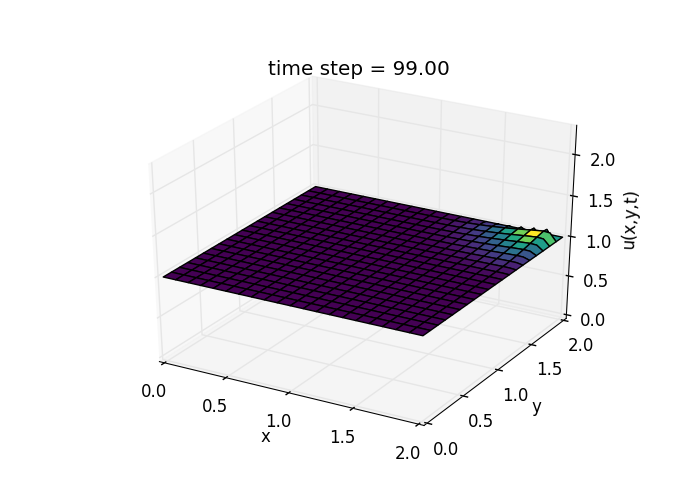

In [3]:
burger2D(2., 2., 41, 41)